In [36]:
pip install --upgrade torch

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
from google.cloud import bigquery
import pandas_gbq
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import DistilBertTokenizer, DistilBertModel
import tensorflow as tf
from tensorflow.keras import layers, models
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import os
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [30]:
!rm /opt/conda/lib/python3.7/site-packages/nvidia/cublas/lib/libcublas.so.11

In [42]:
reviewgoogle = pandas_gbq.read_gbq("SELECT * FROM `prometheus-data-solutions.Datawarehouse_prometheus.google_nlp`")

Downloading: 100%|██████████|


In [4]:
reviewgoogle1= reviewgoogle.copy()

In [43]:
reviewgoogle['comment'] = reviewgoogle['comment'].apply(lambda x: x.strip().replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('\'', ' ').replace('\"', ' ').replace('\\', ' '))                 
# Define the regular expression pattern for special characters
special_char_pattern = '[^A-Za-z0-9\s.,!?]'

# Replace special characters in the 'comment' column with an empty string
reviewgoogle['comment'] = reviewgoogle['comment'].str.replace(special_char_pattern, '')
reviewgoogle['comment'] = reviewgoogle['comment'].apply(lambda x: re.sub(r'\s+', ' ', x))
reviewgoogle['comment'] = reviewgoogle['comment'].apply(lambda x: x.strip())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [44]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

# Apply the normalization function to the 'comment' column
reviewgoogle['comment_normalized'] = reviewgoogle['comment'].apply(normalize_text)

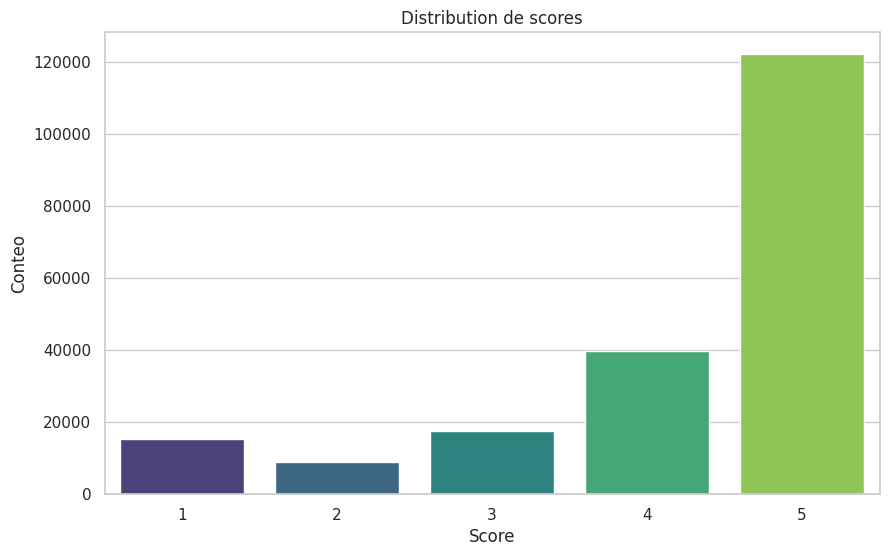

In [11]:
score_counts = reviewgoogle['stars'].value_counts()

# Create a bar plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=score_counts.index, y=score_counts.values, palette="viridis")

# Add labels and title
plt.xlabel('Score')
plt.ylabel('Conteo')
plt.title('Distribution de scores')

# Show the plot
plt.show()

In [7]:
reviewgoogle.stars.value_counts()

5    122013
4     39682
3     17570
1     15454
2      8876
Name: stars, dtype: Int64

In [45]:
# Specify the number of rows to randomly select for each unique value
num_rows_to_select = 8876

# Create an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Iterate over unique values in the 'stars' column
for unique_value in reviewgoogle['stars'].unique():
    # Select randomly 'num_rows_to_select' rows for each unique value
    sampled_rows = reviewgoogle[reviewgoogle['stars'] == unique_value].sample(n=num_rows_to_select, random_state=42)
    
    # Append the sampled rows to the result DataFrame
    sampled_data = pd.concat([sampled_data, sampled_rows])



In [46]:
sampled_data = sampled_data.rename(columns={'comment_normalized': 'review', 'stars': 'score'})
# Drop the 'comment' column
sampled_data = sampled_data.drop(columns=['comment'])

In [35]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44380 entries, 150 to 115750
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   id      44380 non-null  object             
 1   name    44380 non-null  object             
 2   date    44380 non-null  datetime64[ns, UTC]
 3   score   44380 non-null  Int64              
 4   source  44380 non-null  object             
 5   review  44380 non-null  object             
dtypes: Int64(1), datetime64[ns, UTC](1), object(4)
memory usage: 2.4+ MB


In [2]:
sampled_data.score.value_counts()

NameError: name 'sampled_data' is not defined

In [ ]:
********************************************************************************************************

In [47]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    reviewgoogle['comment_normalized'], reviewgoogle['stars'], test_size=0.2, random_state=42
)

# Combine training and testing data to find the maximum sequence length
all_text = pd.concat([X_train, X_test])
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(all_text)
max_sequence_length = max(map(len, tokenizer.texts_to_sequences(all_text)))

# Tokenize the text
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
X_train_padded = pad_sequences(X_train_sequences, padding='post', maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, padding='post', maxlen=max_sequence_length)

# Convert sentiment scores to categorical format
y_train_categorical = tf.keras.utils.to_categorical(y_train - 1, num_classes=5)  # Assuming scores are 1 to 5
y_test_categorical = tf.keras.utils.to_categorical(y_test - 1, num_classes=5)



In [48]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# Build the sentiment analysis model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))  # Assuming 5 classes (1 to 5 scores)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Epoch 1/7
5090/5090 [==============================] - 2087s 410ms/step - loss: 1.1732 - accuracy: 0.5985 - val_loss: 1.1651 - val_accuracy: 0.6022
Epoch 2/7
5090/5090 [==============================] - 2081s 409ms/step - loss: 1.1714 - accuracy: 0.5986 - val_loss: 1.1646 - val_accuracy: 0.6022
Epoch 3/7
5090/5090 [==============================] - 2090s 411ms/step - loss: 1.1713 - accuracy: 0.5986 - val_loss: 1.1648 - val_accuracy: 0.6022
Epoch 4/7
5090/5090 [==============================] - 2069s 406ms/step - loss: 1.1711 - accuracy: 0.5986 - val_loss: 1.1651 - val_accuracy: 0.6022
Epoch 5/7
5090/5090 [==============================] - 2028s 399ms/step - loss: 1.1714 - accuracy: 0.5985 - val_loss: 1.1648 - val_accuracy: 0.6022
Epoch 6/7
5090/5090 [==============================] - 2041s 401ms/step - loss: 1.1710 - accuracy: 0.5986 - val_loss: 1.1644 - val_accuracy: 0.6022
Epoch 7/7
5090/5090 [==============================] - 2054s 404ms/step - loss: 1.1710 - accuracy: 0.5986 - val_

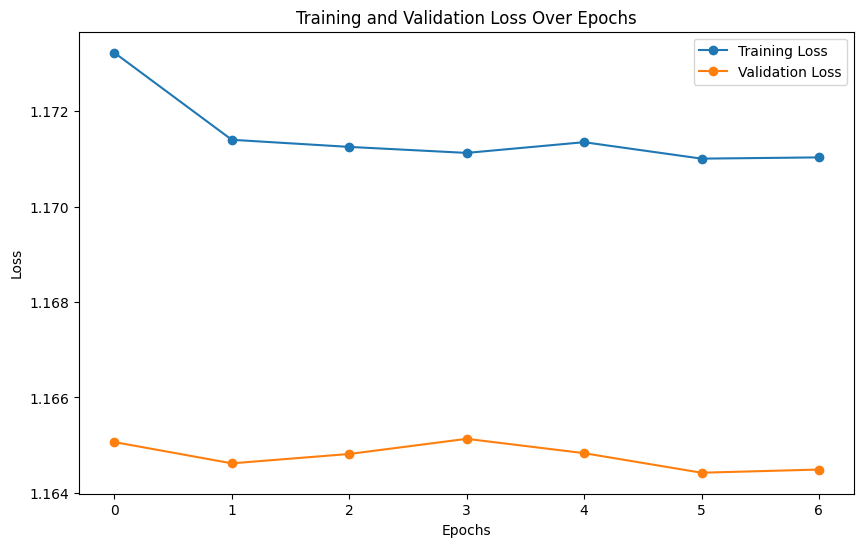

In [49]:
# Train the model and store the training history
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(X_train_padded, y_train_categorical, epochs=7, validation_data=(X_test_padded, y_test_categorical), callbacks=[early_stopping])

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

1273/1273 [==============================] - 145s 114ms/step - loss: 1.1645 - accuracy: 0.6022
Test Loss: 1.1645, Test Accuracy: 60.22%


In [77]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(y_true, y_pred, target_names=["1", "2", "3", "4", "5"]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1828
           2       0.20      1.00      0.33      1736
           3       0.00      0.00      0.00      1758
           4       0.00      0.00      0.00      1769
           5       0.00      0.00      0.00      1785

    accuracy                           0.20      8876
   macro avg       0.04      0.20      0.07      8876
weighted avg       0.04      0.20      0.06      8876



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


278/278 [==============================] - 32s 112ms/step


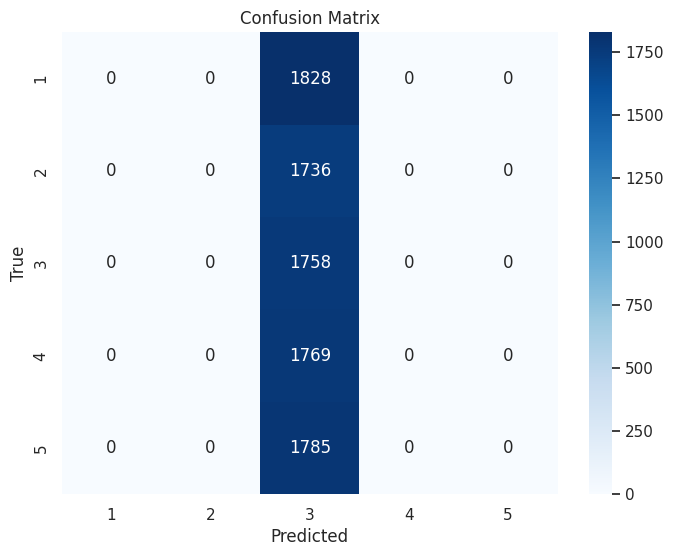

In [78]:
# Get predictions for the test set
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert class labels to integers (if needed)
y_true = y_test.astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
reviewyelp = pandas_gbq.read_gbq("SELECT * FROM `prometheus-data-solutions.Datawarehouse_prometheus.yelp_nlp`")

Downloading: 100%|██████████|


In [21]:
reviewyelp['comment'] = reviewyelp['comment'].apply(lambda x: x.strip().replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('\'', ' ').replace('\"', ' ').replace('\\', ' '))                 
# Define the regular expression pattern for special characters
special_char_pattern = '[^A-Za-z0-9\s.,!?]'

# Replace special characters in the 'comment' column with an empty string
reviewyelp['comment'] = reviewyelp['comment'].str.replace(special_char_pattern, '')
reviewyelp['comment'] = reviewyelp['comment'].apply(lambda x: re.sub(r'\s+', ' ', x))
reviewyelp['comment'] = reviewyelp['comment'].apply(lambda x: x.strip())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [22]:
reviewyelp['comment_normalized'] = reviewyelp['comment'].apply(normalize_text)

In [23]:
reviewyelp = reviewyelp.rename(columns={'comment_normalized': 'review', 'stars': 'score'})
# Drop the 'comment' column
reviewyelp = reviewyelp.drop(columns=['comment'])

In [85]:
reviewyelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983489 entries, 0 to 1983488
Data columns (total 6 columns):
 #   Column  Dtype              
---  ------  -----              
 0   id      object             
 1   name    object             
 2   date    datetime64[ns, UTC]
 3   score   Int64              
 4   source  object             
 5   review  object             
dtypes: Int64(1), datetime64[ns, UTC](1), object(4)
memory usage: 92.7+ MB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'reviewyelp' is your DataFrame
# Assuming 'review' is the column with normalized text
# Assuming 'ML_scores' is the column where you want to store the scores

# Split the DataFrame into 20 smaller DataFrames
dfs = [reviewyelp.iloc[i:i + len(reviewyelp) // 20] for i in range(0, len(reviewyelp), len(reviewyelp) // 20)]

# Initialize the 'ML_scores' column with zeros
for df in dfs:
    df['ML_scores'] = 0

# Tokenize the text
for df in dfs:
    X_new_sequences = tokenizer.texts_to_sequences(df['review'])
    X_new_padded = pad_sequences(X_new_sequences, padding='post', maxlen=max_sequence_length)

    # Make predictions
    y_new_pred = model.predict(X_new_padded).argmax(axis=1) + 1

    # Map predictions to original scores
    df['ML_scores'] = y_new_pred

# Concatenate the 20 DataFrames
result_df = pd.concat(dfs, ignore_index=True)

# Save the result DataFrame with ML_scores
result_df.to_csv('result_with_ML_scores.csv', index=False)


In [88]:
# Assuming 'reviewyelp' is your new DataFrame
reviewyelp['ML_scores'] = 0  # Initialize the 'ML_scores' column with zeros

batch_size = 100000

for start_idx in range(0, len(reviewyelp), batch_size):
    end_idx = start_idx + batch_size if start_idx + batch_size < len(reviewyelp) else len(reviewyelp)
    X_batch = tokenizer.texts_to_sequences(reviewyelp['review'].iloc[start_idx:end_idx])
    X_batch_padded = pad_sequences(X_batch, padding='post', maxlen=max_sequence_length)
    y_batch_pred = model.predict(X_batch_padded).argmax(axis=1) + 1

    # Map predictions to original scores for the batch
    reviewyelp['ML_scores'].iloc[start_idx:end_idx] = y_batch_pred + 1

# Handle the last batch if its size is less than the specified batch_size
if len(reviewyelp) % batch_size != 0:
    start_idx = len(reviewyelp) - len(reviewyelp) % batch_size
    X_batch = tokenizer.texts_to_sequences(reviewyelp['review'].iloc[start_idx:])
    X_batch_padded = pad_sequences(X_batch, padding='post', maxlen=max_sequence_length)
    y_batch_pred = model.predict(X_batch_padded).argmax(axis=1) + 1
    reviewyelp['ML_scores'].iloc[start_idx:] = y_batch_pred + 1

3125/3125 [==============================] - 351s 112ms/step


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


3125/3125 [==============================] - 355s 113ms/step


MemoryError: Unable to allocate 311. MiB for an array with shape (100000, 815) and data type int32

In [ ]:
from google.cloud import storage
reviewyelp.to_csv('2yelp_nlp_executed.csv')
# Set your Google Cloud Storage bucket name and CSV file name
bucket_name = 'bucket_prometheus'
file_name = '2yelp_nlp_executed.csv'

# Create a storage client
client = storage.Client()

# Get the bucket
bucket = client.get_bucket(bucket_name)

# Upload the file to the bucket
blob = bucket.blob(file_name)
blob.upload_from_filename(file_name)

In [93]:
# Create a DataFrame named 'test1' with the first 100 rows
test1 = sampled_data.head(100).copy()

# Initialize the 'ML_scores' column with zeros
test1['ML_scores'] = 0

# Tokenize the text
X_test1_sequences = tokenizer.texts_to_sequences(test1['review'])
X_test1_padded = pad_sequences(X_test1_sequences, padding='post', maxlen=max_sequence_length)

# Make predictions
y_test1_pred = model.predict(X_test1_padded).argmax(axis=1) + 1

# Map predictions to original scores
test1['ML_scores'] = y_test1_pred

4/4 [==============================] - 0s 92ms/step


In [94]:
test1.head()

,id,name,date,score,source,review,ML_scores
150,0x8834f16938b78605:0x36b4b81b302e54e,Apsara Cafe,2018-09-17 20:33:55+00:00,1,google,online days open at 11am sign outside says 113...,4
9063,0x89c6b3939445c60b:0x52af4ef5a308ee9e,Applebee's Grill + Bar,2019-11-19 00:42:37+00:00,1,google,the service was lousy never came back to the t...,4
3834,0x8834f66e5acafeb9:0x473f6d016db9d58e,Portofino's Pizza & Pasta,2020-08-18 02:30:14+00:00,1,google,there cost has gone up was unbelievable the qu...,4
14413,0x89c9755fddec80df:0x305f8535db11f6fa,Little Vince's Pizza,2020-12-15 18:50:29+00:00,1,google,i tried calling this place after ordering onli...,4
379,0x89c59396104d8691:0xdb8c48eaeb27f24,Park Restaurant,2017-11-13 12:14:12+00:00,1,google,absolutely horrible place would never recommen...,4


In [ ]:
# A BIG QUERY

reviewyelp.to_gbq(destination_table='Datawarehouse_prometheus.yelp_nlp_executed',project_id='prometheus-data-solutions', if_exists='replace')

In [ ]:
NLTK****************************************************

In [13]:
nltk.download('punkt')
nltk.download('stopwords')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    reviewgoogle['comment_normalized'], reviewgoogle['stars'], test_size=0.2, random_state=42
)

# Tokenize, remove stopwords, and apply stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)


In [15]:
# Convert sentiment scores to categorical format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [16]:
# Build and train the sentiment analysis model (Naive Bayes)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train_encoded)


MultinomialNB()

In [17]:
# Evaluate the model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 67.51%


In [18]:
# Print classification report for more detailed metrics
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63      3066
           1       0.38      0.02      0.04      1700
           2       0.47      0.18      0.26      3593
           3       0.44      0.11      0.17      7840
           4       0.70      0.98      0.82     24520

    accuracy                           0.68     40719
   macro avg       0.52      0.39      0.38     40719
weighted avg       0.61      0.68      0.60     40719



In [24]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

# Assuming 'reviewyelp' is your new DataFrame
# Assuming 'review' is the column with normalized text

# Tokenize, remove stopwords, and apply stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the 'review' column in reviewyelp
reviewyelp['review_processed'] = reviewyelp['review'].apply(preprocess_text)

# Convert processed text to TF-IDF features
X_reviewyelp_tfidf = vectorizer.transform(reviewyelp['review_processed'])

# Make predictions using the trained model
y_reviewyelp_pred = model.predict(X_reviewyelp_tfidf)

# Convert predicted labels back to original scores
y_reviewyelp_scores = label_encoder.inverse_transform(y_reviewyelp_pred)

# Add 'ML_scores' column to reviewyelp with the predicted scores
reviewyelp['ML_scores'] = y_reviewyelp_scores

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
reviewyelp

,id,name,date,score,source,review,review_processed,ML_scores
0,-1owBLC2h6DF5n_j77oq3g,Hardee's,2017-06-12 16:40:53+00:00,1,yelp,excellent food and cleanliness it s not a fast...,excel food cleanli fast food servic averag wai...,3
1,-PMXnNJ1D67NkAupRHNkpQ,Domino's Pizza,2018-12-29 06:58:04+00:00,1,yelp,4 minutes ago they told me my order is in the ...,minut ago told order oven minut later cancel o...,1
2,-PMXnNJ1D67NkAupRHNkpQ,Domino's Pizza,2020-02-22 18:13:02+00:00,1,yelp,they reached out to me apologizing for the pro...,reach apolog problem happen offer free pizza g...,1
3,-Pd_tj2g-SGmOeVy718PPA,Pizza Hut,2019-03-02 01:15:15+00:00,1,yelp,i just can t give this more than one star if y...,give one star hunger pizza hut pizza like go p...,5
4,-T_lkOvaK39R-Ufg6VUyxg,Magpie,2016-10-28 22:51:12+00:00,1,yelp,unfortunately i cannot rate the food here as i...,unfortun rate food opportun tri rate custom se...,1
...,...,...,...,...,...,...,...,...
1983484,zutnb4ogWkJuEd3ZyXk3BQ,Lansdale Meats and Deli,2017-05-21 11:18:57+00:00,5,yelp,this is my go to place for all of my cuts of m...,go place cut meat alway fresh low price find s...,5
1983485,zxPcNvM4aPZu6gUmTFkazQ,Wok Chi,2014-11-28 18:49:16+00:00,5,yelp,the food was pretty good i had the spicy szech...,food pretti good spici szechuan sauc chicken e...,5
1983486,zxPcNvM4aPZu6gUmTFkazQ,Wok Chi,2014-11-28 18:49:16+00:00,5,yelp,the food was pretty good i had the spicy szech...,food pretti good spici szechuan sauc chicken e...,5
1983487,zxuVnNVAUm16Sro0dS_lmg,Roundabout Grill,2017-08-05 05:40:24+00:00,5,yelp,my boyfriend and i absolutely loved our experi...,boyfriend absolut love experi waiter wonder su...,5
